In [1]:
from pscore_data_reader_preproc import read_and_process_data, model_evaluation
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in the data using the pre-processing code
x_train, y_train, x_test, y_test, train_team_values, test_team_values = read_and_process_data(
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_train_data.csv",
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_test_data.csv",
     True
)

# check to make sure the data looks right
x_train.shape
x_test.shape

train data has shape: (14648, 490)
test data has shape: (132, 490)


(132, 490)

In [4]:
# Step 1: Define hyperparameter grid
n_estimators_values = [50, 100, 150]  # Number of boosting stages
learning_rate_values = [0.01, 0.1, 0.5, 1.0]  # Learning rate

# Step 2: Create the parameter grid
ada_boost_param_grid = {
    'n_estimators': n_estimators_values,  # Number of boosting stages
    'learning_rate': learning_rate_values  # Learning rate for AdaBoost
}

# Step 3: Set up AdaBoost Regressor model
ada_boost_regressor = AdaBoostRegressor()

# Step 4: Set up GridSearchCV for AdaBoost
ada_boost_grid_search = GridSearchCV(
    estimator=ada_boost_regressor,
    param_grid=ada_boost_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    n_jobs=-3,  # Use all available cores
    verbose=1,  # Output progress
    error_score='raise'  # Raise an error if fitting fails
)

In [5]:
#Step 5: Fit the grid search
ada_boost_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, error_score='raise', estimator=AdaBoostRegressor(),
             n_jobs=-3,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=1)

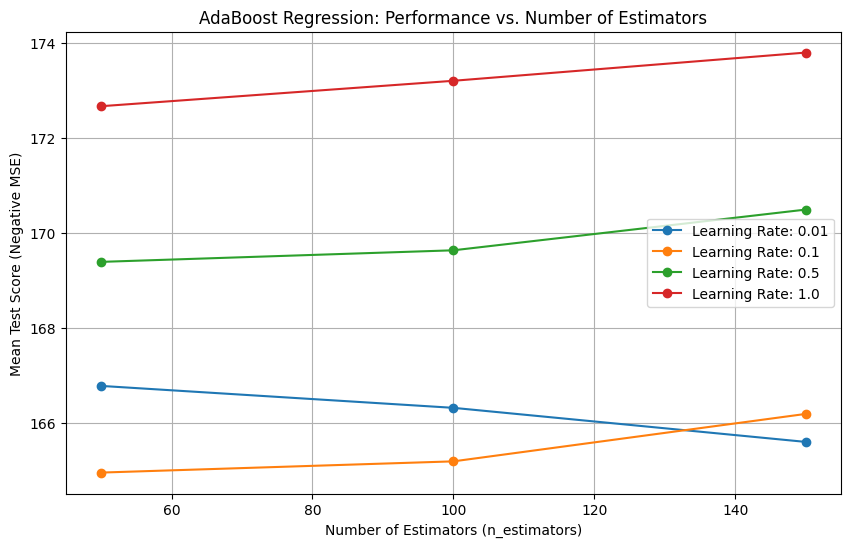

In [7]:
# Extract results from GridSearchCV
ada_results = pd.DataFrame(ada_boost_grid_search.cv_results_)

# Plot performance for different n_estimators grouped by learning_rate
plt.figure(figsize=(10, 6))

for learning_rate in learning_rate_values:  # learning_rate: [0.01, 0.1, 0.5, 1.0]
    subset = ada_results[ada_results['param_learning_rate'] == learning_rate]
    plt.plot(
        subset['param_n_estimators'], 
        -subset['mean_test_score'],  # Negative MSE to positive MSE
        marker='o', 
        label=f'Learning Rate: {learning_rate}'
    )

# Customize plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (Negative MSE)')
plt.title('AdaBoost Regression: Performance vs. Number of Estimators')
plt.legend()
plt.grid()
plt.show()

In [8]:
# Get the best parameters
best_n_estimators_value = ada_boost_grid_search.best_params_['n_estimators']
best_learning_rate_value = ada_boost_grid_search.best_params_['learning_rate']

# Print the best values
print(f"Best n_estimators: {best_n_estimators_value}")
print(f"Best learning_rate: {best_learning_rate_value}")

Best n_estimators: 50
Best learning_rate: 0.1


In [9]:
# fit final model using the best param
best_ada_booster = AdaBoostRegressor(
    n_estimators = best_n_estimators_value,
    learning_rate = best_learning_rate_value
)

best_ada_booster.fit(x_train, y_train)

AdaBoostRegressor(learning_rate=0.1)

In [10]:
# Model evaluation
y_pred_train = best_ada_booster.predict(x_train)

# evaluate model
model_evaluation(y_train, y_pred_train)

# OPE that is BAD lol

R-squared: 0.176
Mean Squared Error (MSE): 161.109
Mean Absolute Error (MAE): 10.289
